In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
from random import *
from torch import nn
from torch import Tensor
from PIL import Image
import numpy as np
import math
from torchsummary import summary

# Parameters

In [2]:
maxlen = 30 # maximum of length
batch_size = 6
max_pred = 5  # max tokens of prediction
n_layers = 6 # number of Encoder of Encoder Layer
n_heads = 12 # number of heads in Multi-Head Attention
d_model = 768 # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

# Data Preprocessing

In [3]:
text = (
       'Hello, how are you? I am Romeo.\n'
       'Hello, Romeo My name is Juliet. Nice to meet you.\n'
       'Nice meet you too. How are you today?\n'
       'Great. My baseball team won the competition.\n'
       'Oh Congratulations, Juliet\n'
       'Thanks you Romeo'
   )

In [4]:
text

'Hello, how are you? I am Romeo.\nHello, Romeo My name is Juliet. Nice to meet you.\nNice meet you too. How are you today?\nGreat. My baseball team won the competition.\nOh Congratulations, Juliet\nThanks you Romeo'

In [5]:
sentences = re.sub("[.,!?\\-]", '', text.lower()).split('\n')  # filter '.', ',', '?', '!', '\n' and lower letter
sentences

['hello how are you i am romeo',
 'hello romeo my name is juliet nice to meet you',
 'nice meet you too how are you today',
 'great my baseball team won the competition',
 'oh congratulations juliet',
 'thanks you romeo']

In [6]:
word_list = list(set(" ".join(sentences).split())) # turn sentences to a dictionary
word_list

['meet',
 'baseball',
 'i',
 'too',
 'competition',
 'today',
 'oh',
 'juliet',
 'thanks',
 'is',
 'to',
 'romeo',
 'team',
 'am',
 'nice',
 'great',
 'are',
 'name',
 'how',
 'my',
 'won',
 'hello',
 'you',
 'congratulations',
 'the']

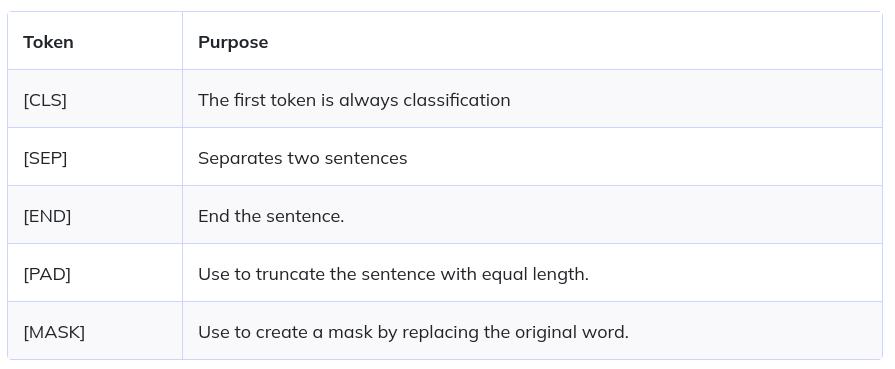

In [7]:
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
print(word_dict)
for i, w in enumerate(word_list):
    word_dict[w] = i + 4 # add elements to the dictionary
    print(word_dict)
    number_dict = {i: w for i, w in enumerate(word_dict)}# switch key and values
    print(number_dict)
    vocab_size = len(word_dict)
    print(vocab_size)

{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}
{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'meet': 4}
{0: '[PAD]', 1: '[CLS]', 2: '[SEP]', 3: '[MASK]', 4: 'meet'}
5
{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'meet': 4, 'baseball': 5}
{0: '[PAD]', 1: '[CLS]', 2: '[SEP]', 3: '[MASK]', 4: 'meet', 5: 'baseball'}
6
{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'meet': 4, 'baseball': 5, 'i': 6}
{0: '[PAD]', 1: '[CLS]', 2: '[SEP]', 3: '[MASK]', 4: 'meet', 5: 'baseball', 6: 'i'}
7
{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'meet': 4, 'baseball': 5, 'i': 6, 'too': 7}
{0: '[PAD]', 1: '[CLS]', 2: '[SEP]', 3: '[MASK]', 4: 'meet', 5: 'baseball', 6: 'i', 7: 'too'}
8
{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'meet': 4, 'baseball': 5, 'i': 6, 'too': 7, 'competition': 8}
{0: '[PAD]', 1: '[CLS]', 2: '[SEP]', 3: '[MASK]', 4: 'meet', 5: 'baseball', 6: 'i', 7: 'too', 8: 'competition'}
9
{'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3, 'meet': 4, 'baseball': 5, 'i': 6, 't

In [8]:
token_list = list()
print(token_list)
for sentence in sentences:
    arr = [word_dict[s] for s in sentence.split()]
    token_list.append(arr)
    print(token_list)

[]
[[25, 22, 20, 26, 6, 17, 15]]
[[25, 22, 20, 26, 6, 17, 15], [25, 15, 23, 21, 13, 11, 18, 14, 4, 26]]
[[25, 22, 20, 26, 6, 17, 15], [25, 15, 23, 21, 13, 11, 18, 14, 4, 26], [18, 4, 26, 7, 22, 20, 26, 9]]
[[25, 22, 20, 26, 6, 17, 15], [25, 15, 23, 21, 13, 11, 18, 14, 4, 26], [18, 4, 26, 7, 22, 20, 26, 9], [19, 23, 5, 16, 24, 28, 8]]
[[25, 22, 20, 26, 6, 17, 15], [25, 15, 23, 21, 13, 11, 18, 14, 4, 26], [18, 4, 26, 7, 22, 20, 26, 9], [19, 23, 5, 16, 24, 28, 8], [10, 27, 11]]
[[25, 22, 20, 26, 6, 17, 15], [25, 15, 23, 21, 13, 11, 18, 14, 4, 26], [18, 4, 26, 7, 22, 20, 26, 9], [19, 23, 5, 16, 24, 28, 8], [10, 27, 11], [12, 26, 15]]


In [9]:
def make_batch():
    batch = []
    positive = negative = 0
    
    while positive != batch_size/2 or negative != batch_size/2:
        
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences)) 
        print("tokens_a_index", tokens_a_index) # 1
        print("tokens_b_index", tokens_b_index) # 3

        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]
        # choose token version of sentence a & b
        print("tokens_a", tokens_a)
        print("tokens_b", tokens_b)

        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
        # 1 + token_a + 2 + token_b + 2
        print("input_ids",input_ids)


        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)
        #[0,0,0,..,0,1,1,..,1]
        print("segment_ids",segment_ids)

        # MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence
        print('n_pred', n_pred) # 3
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                         if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        # remove index for special notations
        print('cand_maked_pos',cand_maked_pos)
       
        shuffle(cand_maked_pos)
        print('cand_maked_pos',cand_maked_pos)
        # shuffle in order to randomly select masked token
        
        masked_tokens, masked_pos = [], []
        
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            
            print('masked_pos',masked_pos) # 16
            print('masked_tokens',masked_tokens) # 27
            
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                print('index',index) # 0
                input_ids[pos] = word_dict[number_dict[index]] # replace
            
            print('input_ids',input_ids)

            # Zero Paddings
            n_pad = maxlen - len(input_ids)
            print(n_pad,'n_pad') # 10
            input_ids.extend([0] * n_pad)
            print('input_ids',input_ids)
            segment_ids.extend([0] * n_pad) #[0,0,0,..,0,1,1,..,1,0,..,0]
            print('segment_ids',segment_ids)

           # Zero Padding (100% - 15%) tokens
            if max_pred > n_pred:
                n_pad = max_pred - n_pred # space that needs to pad
                print(n_pad,'n_pad') # 2
                masked_tokens.extend([0] * n_pad) 
                masked_pos.extend([0] * n_pad) 
                print('masked_tokens',masked_tokens)# [27, 0, 0]
                print('masked_pos',masked_pos)# [16, 0, 0]
            
            if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2: # if a & b are near 
                batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
                #[sentence pair, sentence location, masked tokens, masked_pos, IsNext]
                positive += 1
                print('positive',positive)
                print('batch',batch)
            elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
                batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
                negative += 1
                print('negative',negative)
                print('batch',batch)
                
    
    return batch

In [10]:
make_batch() # 3 IsNext & 3 NotNext

tokens_a_index 3
tokens_b_index 3
tokens_a [19, 23, 5, 16, 24, 28, 8]
tokens_b [19, 23, 5, 16, 24, 28, 8]
input_ids [1, 19, 23, 5, 16, 24, 28, 8, 2, 19, 23, 5, 16, 24, 28, 8, 2]
segment_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
n_pred 3
cand_maked_pos [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]
cand_maked_pos [5, 11, 13, 15, 4, 10, 14, 12, 2, 3, 6, 9, 1, 7]
masked_pos [5]
masked_tokens [24]
input_ids [1, 19, 23, 5, 16, 3, 28, 8, 2, 19, 23, 5, 16, 24, 28, 8, 2]
13 n_pad
input_ids [1, 19, 23, 5, 16, 3, 28, 8, 2, 19, 23, 5, 16, 24, 28, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
segment_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2 n_pad
masked_tokens [24, 0, 0]
masked_pos [5, 0, 0]
negative 1
batch [[[1, 19, 23, 5, 16, 3, 28, 8, 2, 19, 23, 5, 16, 24, 28, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [24, 0, 0], [5, 0, 0], False

[[[1,
   19,
   23,
   5,
   16,
   3,
   28,
   8,
   2,
   19,
   23,
   3,
   16,
   3,
   28,
   8,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [24, 0, 0, 5, 0, 0, 24, 0, 0],
  [5, 0, 0, 11, 0, 0, 13, 0, 0],
  False],
 [[1,
   19,
   23,
   5,
   16,
   3,
   28,
   8,
   2,
   19,
   23,
   3,
   16,
   3,
   28,
   8,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [24, 0, 0, 5, 0, 0, 24, 0, 0],
  [5, 0, 0, 11, 0, 0, 13, 0, 0],
  False],
 [[1,
   19,
   23,
   5,
   16,
   3,
   28,
   8,
   2,
   19,
   23,
   3,
   16,
   3,
   28,
   8,
   2

In [11]:
def make_batch():
    batch = []
    positive = negative = 0
    while positive != batch_size/2 or negative != batch_size/2:
        tokens_a_index, tokens_b_index= randrange(len(sentences)), randrange(len(sentences)) # sample random index in sentences
        tokens_a, tokens_b= token_list[tokens_a_index], token_list[tokens_b_index]
        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        # MASK LM
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                          if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
    return batch

# Function

In [12]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    print('pad_attn_mask',pad_attn_mask)
    print('pad_attn_mask shape ',pad_attn_mask.shape)
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [13]:
test_k = torch.rand(size=(2,3))
test_q = torch.rand(size=(2,3))
print('test_k',test_k)
print('test_q',test_q)

test_k tensor([[0.7354, 0.1330, 0.0744],
        [0.5275, 0.7637, 0.3040]])
test_q tensor([[0.6224, 0.5264, 0.0902],
        [0.8424, 0.0373, 0.2110]])


In [14]:
test_pad = get_attn_pad_mask(test_q, test_k)
print(test_pad)
print(test_pad.shape)

pad_attn_mask tensor([[[False, False, False]],

        [[False, False, False]]])
pad_attn_mask shape  torch.Size([2, 1, 3])
tensor([[[False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False]]])
torch.Size([2, 3, 3])


In [15]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [16]:
def gelu(x):
    "Implementation of the gelu activation function by Hugging Face"
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

# Embedding

In [17]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding [29, 768]
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding [30, 768]
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding [2, 768]
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        print('x: ',x.shape)
        print('seg: ',seg.shape)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        print('pos: ',pos.shape)
        print('self.tok_embed(x): ', self.tok_embed(x).shape)
        print('self.pos_embed(pos): ', self.pos_embed(pos).shape)
        print('self.seg_embed(seg): ', self.seg_embed(seg).shape)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        print('embedding: ', embedding.shape)
        return self.norm(embedding)

In [18]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*make_batch()))

In [19]:
input_ids.shape # [batch_size, maxlen]

torch.Size([6, 30])

In [20]:
segment_ids.shape # [batch_size, maxlen]

torch.Size([6, 30])

In [21]:
masked_tokens.shape # [batch_size, max_pred]

torch.Size([6, 5])

In [22]:
masked_tokens

tensor([[21, 13,  0,  0,  0],
        [22, 15,  0,  0,  0],
        [11, 26, 11,  0,  0],
        [18, 21,  4,  0,  0],
        [26, 17,  6,  0,  0],
        [27,  5,  0,  0,  0]])

In [23]:
masked_pos.shape # [batch_size, max_pred]

torch.Size([6, 5])

In [24]:
isNext.shape # [batch_size]

torch.Size([6])

In [25]:
Embedding()(input_ids, segment_ids)

x:  torch.Size([6, 30])
seg:  torch.Size([6, 30])
pos:  torch.Size([6, 30])
self.tok_embed(x):  torch.Size([6, 30, 768])
self.pos_embed(pos):  torch.Size([6, 30, 768])
self.seg_embed(seg):  torch.Size([6, 30, 768])
embedding:  torch.Size([6, 30, 768])


tensor([[[-9.9661e-02, -6.5247e-01,  4.9522e-02,  ...,  1.6345e-01,
          -1.3146e+00,  6.7911e-01],
         [-1.3974e+00,  1.1710e+00, -9.8288e-01,  ..., -1.4408e+00,
          -4.0601e-02,  5.5455e-01],
         [-3.5131e-01,  1.0788e+00, -7.0177e-01,  ...,  1.4450e-01,
          -5.9342e-01, -1.1547e+00],
         ...,
         [ 6.0104e-01, -1.6132e-01,  7.4835e-01,  ...,  5.0660e-01,
          -6.5927e-01, -5.4013e-02],
         [-4.1610e-02, -8.9943e-01,  5.9076e-01,  ...,  6.1654e-01,
          -9.6809e-01,  1.0547e+00],
         [-4.2931e-01, -5.0186e-01,  1.0174e+00,  ...,  6.7673e-01,
          -1.0043e+00,  8.1259e-01]],

        [[-9.9661e-02, -6.5247e-01,  4.9522e-02,  ...,  1.6345e-01,
          -1.3146e+00,  6.7911e-01],
         [-1.1510e+00,  2.5594e-01, -4.5643e-01,  ..., -1.7168e-01,
          -5.8113e-01,  1.3377e+00],
         [-2.3490e-01,  1.0712e+00, -6.1190e-02,  ..., -1.8848e-01,
          -1.4327e+00,  1.4820e-01],
         ...,
         [ 6.0104e-01, -1

In [26]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

# Transformer

In [27]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        # bnqd * bndk -> bnqk
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores) #bnqk
        context = torch.matmul(attn, V)
        # bnqk * bnvd -> bnqd (k=v)
        return context, attn

In [28]:
input_ids

tensor([[ 1, 12, 26, 15,  2, 25, 15, 23,  3,  4, 11, 18, 14,  4, 26,  2,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 25,  3, 20, 26,  6, 17, 15,  2, 12, 26,  3,  2,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 25, 15, 23, 21, 13,  3, 18, 14,  4, 26,  2, 25, 15, 23, 21, 13,  3,
         18, 14,  4,  3,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 25, 15, 23,  3, 13, 11, 18, 14,  3, 26,  2,  3,  4, 26,  7, 22, 20,
         26,  9,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 25, 22, 20,  3,  3,  3, 15,  2, 25, 15, 23, 21, 13, 11, 18, 14,  4,
         26,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 19, 23,  3, 16, 24, 28,  8,  2, 10,  3, 11,  2,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [29]:
get_attn_pad_mask(input_ids, input_ids).shape

torch.Size([6, 30, 30])

In [30]:
get_attn_pad_mask(input_ids, input_ids)[1]

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, Fals

### A contiguous tensor is a tensor whose elements are stored in a contiguous order without leaving any empty space between them. A tensor created originally is always a contiguous tensor. A tensor can be viewed with different dimensions in contiguous manner.

A transpose of a tensor creates a view of the original tensor which follows non-contiguous order. The transpose of a tensor is non-contiguous.

In [31]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads) # project to 12 heads
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  
        # q_s: [batch_size x n_heads x len_q x d_k] [6, 12, 30, 64]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  
        # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  
        # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) 
        # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], 
        # attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) 
        # context: [batch_size x len_q x n_heads * d_v]
        # bnqd -> bqnd -> bq(n*d)
        output = nn.Linear(n_heads * d_v, d_model)(context)
        return nn.LayerNorm(d_model)(output + residual), attn # output: [batch_size x len_q x d_model]
        # attn is the score


In [32]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(gelu(self.fc1(x)))

In [33]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

In [34]:
[EncoderLayer() for _ in range(n_layers)]

[EncoderLayer(
   (enc_self_attn): MultiHeadAttention(
     (W_Q): Linear(in_features=768, out_features=768, bias=True)
     (W_K): Linear(in_features=768, out_features=768, bias=True)
     (W_V): Linear(in_features=768, out_features=768, bias=True)
   )
   (pos_ffn): PoswiseFeedForwardNet(
     (fc1): Linear(in_features=768, out_features=3072, bias=True)
     (fc2): Linear(in_features=3072, out_features=768, bias=True)
   )
 ),
 EncoderLayer(
   (enc_self_attn): MultiHeadAttention(
     (W_Q): Linear(in_features=768, out_features=768, bias=True)
     (W_K): Linear(in_features=768, out_features=768, bias=True)
     (W_V): Linear(in_features=768, out_features=768, bias=True)
   )
   (pos_ffn): PoswiseFeedForwardNet(
     (fc1): Linear(in_features=768, out_features=3072, bias=True)
     (fc2): Linear(in_features=3072, out_features=768, bias=True)
   )
 ),
 EncoderLayer(
   (enc_self_attn): MultiHeadAttention(
     (W_Q): Linear(in_features=768, out_features=768, bias=True)
     (W_K): Li

In [35]:
Embedding()

Embedding(
  (tok_embed): Embedding(29, 768)
  (pos_embed): Embedding(30, 768)
  (seg_embed): Embedding(2, 768)
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [36]:
Embedding().tok_embed

Embedding(29, 768)

In [37]:
Embedding().tok_embed.weight

Parameter containing:
tensor([[-1.0918,  1.3855, -1.7424,  ..., -0.0512,  0.9755,  0.3623],
        [-1.0756, -0.2863, -0.9207,  ..., -2.1330,  0.0410, -0.3889],
        [ 0.5531, -0.7208,  0.4380,  ...,  0.2942, -0.1436,  0.5685],
        ...,
        [ 0.7188,  0.9811, -0.9178,  ...,  0.1899,  0.3802,  1.6373],
        [-0.4209, -0.6946, -0.5199,  ..., -0.8769, -1.7347, -0.7922],
        [-0.3904,  0.7730, -1.3695,  ..., -0.4987,  1.1214, -0.3514]],
       requires_grad=True)

In [38]:
masked_pos

tensor([[ 8,  9,  0,  0,  0],
        [ 2, 11,  0,  0,  0],
        [ 6, 21, 17,  0,  0],
        [12,  4,  9,  0,  0],
        [ 4,  6,  5,  0,  0],
        [10,  3,  0,  0,  0]])

In [39]:
masked_pos[:, :, None]

tensor([[[ 8],
         [ 9],
         [ 0],
         [ 0],
         [ 0]],

        [[ 2],
         [11],
         [ 0],
         [ 0],
         [ 0]],

        [[ 6],
         [21],
         [17],
         [ 0],
         [ 0]],

        [[12],
         [ 4],
         [ 9],
         [ 0],
         [ 0]],

        [[ 4],
         [ 6],
         [ 5],
         [ 0],
         [ 0]],

        [[10],
         [ 3],
         [ 0],
         [ 0],
         [ 0]]])

In [40]:
masked_pos[:, :, None].expand(-1, -1, 768)

tensor([[[ 8,  8,  8,  ...,  8,  8,  8],
         [ 9,  9,  9,  ...,  9,  9,  9],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 2,  2,  2,  ...,  2,  2,  2],
         [11, 11, 11,  ..., 11, 11, 11],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 6,  6,  6,  ...,  6,  6,  6],
         [21, 21, 21,  ..., 21, 21, 21],
         [17, 17, 17,  ..., 17, 17, 17],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[12, 12, 12,  ..., 12, 12, 12],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 9,  9,  9,  ...,  9,  9,  9],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 4,  4,  4,  ...,  4,  4,  4],
         [ 6,  6,  6,  ...,  6,  6,  6],
         [ 5,  5,  5,  ...,  5,  5,  5],
         [ 0,  0,  0,  ...,  0,  0,  0],
        

In [41]:
masked_pos[:, :, None].expand(-1, -1, 768).shape

torch.Size([6, 5, 768])

In [42]:
t = torch.tensor([[1, 2], [3, 4]])
print(t)
torch.gather(t, 1, torch.tensor([[0, 0], [1, 0]]))

tensor([[1, 2],
        [3, 4]])


tensor([[1, 1],
        [4, 3]])

In [43]:
nn.Linear(768, 768)(torch.rand(size=(6,5,768))).shape

torch.Size([6, 5, 768])

In [44]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight # [29,768]
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False) # nn.Linear(768, 29)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab)) # nn.Parameter(zeros(29))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) 
        # [batch_size, len, d_model] -> [batch_size, d_model] -> [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) 
        # [batch_size, d_model] -> [batch_size, 2] IsNext or NotNext 
        # Next Sentence Prediction

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) 
        # [batch_size, max_pred, d_model] [6, 5] -> [6, 5, 1] -> [6, 5, 768]
        
        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) 
        # masking position [batch_size, max_pred, d_model] 
        # [6, 30, 768] gather [6, 5] -> [6, 5, 768]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        # [6, 5, 768] -> [6, 5, 768]
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]
        # [6, 5, 768] -> [6, 5, 29]

        return logits_lm, logits_clsf

# Execution

In [45]:
model = BERT()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
batch = make_batch()
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

In [47]:
for epoch in range(100):
    optimizer.zero_grad()
    logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos) # MLM & NSP
    if epoch == 0:
        print('logits_lm: ',logits_lm.shape)
        print('logits_clsf: ',logits_clsf.shape)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
    if epoch == 0:
        print('logits_lm: ',logits_lm.shape)
    loss_lm = (loss_lm.float()).mean()
    if epoch == 0:
        print('logits_lm: ',logits_lm.shape)
    loss_clsf = criterion(logits_clsf, isNext) # for sentence classification
    loss = loss_lm + loss_clsf
    if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

logits_lm:  torch.Size([6, 5, 29])
logits_clsf:  torch.Size([6, 2])
logits_lm:  torch.Size([6, 5, 29])
logits_lm:  torch.Size([6, 5, 29])
Epoch: 0010 cost = 57.128986
Epoch: 0020 cost = 38.771671
Epoch: 0030 cost = 25.818384
Epoch: 0040 cost = 15.286547
Epoch: 0050 cost = 12.659238
Epoch: 0060 cost = 10.557425
Epoch: 0070 cost = 9.461622
Epoch: 0080 cost = 8.764488
Epoch: 0090 cost = 8.010417
Epoch: 0100 cost = 7.274577


In [48]:
number_dict

{0: '[PAD]',
 1: '[CLS]',
 2: '[SEP]',
 3: '[MASK]',
 4: 'meet',
 5: 'baseball',
 6: 'i',
 7: 'too',
 8: 'competition',
 9: 'today',
 10: 'oh',
 11: 'juliet',
 12: 'thanks',
 13: 'is',
 14: 'to',
 15: 'romeo',
 16: 'team',
 17: 'am',
 18: 'nice',
 19: 'great',
 20: 'are',
 21: 'name',
 22: 'how',
 23: 'my',
 24: 'won',
 25: 'hello',
 26: 'you',
 27: 'congratulations',
 28: 'the'}

In [49]:
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(batch[0]))
print(text)
print([number_dict[w.item()] for w in input_ids[0] if number_dict[w.item()] != '[PAD]'])

Hello, how are you? I am Romeo.
Hello, Romeo My name is Juliet. Nice to meet you.
Nice meet you too. How are you today?
Great. My baseball team won the competition.
Oh Congratulations, Juliet
Thanks you Romeo
['[CLS]', 'hello', '[MASK]', 'are', 'you', 'name', 'am', 'romeo', '[SEP]', 'oh', 'congratulations', 'juliet', '[SEP]']


In [50]:
logits_lm, logits_clsf = model(input_ids, segment_ids, masked_pos)

In [51]:
logits_lm

tensor([[[  19.4711,   -0.4004,   12.4680,  -14.0396,    4.6071,   11.7006,
            17.1605,  -15.2496,  -10.6696,   17.4949,    6.0434,   -4.6534,
             8.8767,   16.2571,    8.7028,   16.7239,  -67.0431,   17.9637,
            -6.5010,  -74.5477,   17.7200,  -26.0919, -121.6428,    5.0577,
             2.4529,   17.5209,   14.9354,   17.7845,   18.0313],
         [  19.4762,   -0.3987,   12.4685,  -14.0417,    4.6062,   11.6996,
            17.1626,  -15.2510,  -10.6721,   17.4949,    6.0416,   -4.6557,
             8.8750,   16.2597,    8.7023,   16.7282,  -67.0418,   17.9609,
            -6.4989,  -74.5493,   17.7228,  -26.0881, -121.6462,    5.0563,
             2.4545,   17.5210,   14.9338,   17.7816,   18.0284],
         [  19.6477,   -0.3452,   12.4838,  -14.1073,    4.5732,   11.6716,
            17.2234,  -15.2846,  -10.7528,   17.4903,    5.9910,   -4.7248,
             8.8163,   16.3370,    8.6900,   16.8766,  -66.9971,   17.8893,
            -6.4307,  -74.5935, 

In [52]:
logits_lm.shape

torch.Size([1, 5, 29])

In [53]:
logits_lm.data.max(2)

torch.return_types.max(
values=tensor([[19.4711, 19.4762, 19.6477, 19.6477, 19.6477]]),
indices=tensor([[0, 0, 0, 0, 0]]))

In [54]:
logits_lm.data.max(2)[1]

tensor([[0, 0, 0, 0, 0]])

In [55]:
logits_lm.data.max(2)[1][0]

tensor([0, 0, 0, 0, 0])

In [56]:
masked_tokens

tensor([[ 6, 22,  0,  0,  0]])

In [57]:
masked_tokens[0]

tensor([ 6, 22,  0,  0,  0])

In [58]:
logits_lm_re = logits_lm.data.max(2)[1][0].data.numpy()
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predict masked tokens list : ',[pos for pos in logits_lm_re if pos != 0])

masked tokens list :  [6, 22]
predict masked tokens list :  []


In [59]:
logits_clsf

tensor([[-0.1726, -0.1726]], grad_fn=<AddmmBackward0>)

In [60]:
logits_clsf.data.max(1)

torch.return_types.max(
values=tensor([-0.1726]),
indices=tensor([1]))

In [61]:
logits_clsf.data.max(1)[1]

tensor([1])

In [62]:
logits_clsf.data.max(1)[1].data.numpy()[0]

1

In [64]:
logits_clsf_re = logits_clsf.data.max(1)[1].data.numpy()[0]
print('isNext : ', True if isNext else False)
print('predict isNext : ',True if logits_clsf_re else False)

isNext :  False
predict isNext :  True
